In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [2]:
DATA_PATH = Path("../data/raw/complaints.csv")

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


C:\Users\deres\AppData\Local\Temp\ipykernel_14576\2895374729.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Dataset shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [4]:
df.isna().sum().sort_values(ascending=False)


Tags                            8981029
Consumer disputed?              8841498
Consumer complaint narrative    6629041
Company public response         4770207
Consumer consent provided?      1649561
Sub-issue                        839522
Sub-product                      235295
State                             54516
ZIP code                          30228
Company response to consumer         20
Issue                                 6
Date received                         0
Product                               0
Company                               0
Date sent to company                  0
Submitted via                         0
Timely response?                      0
Complaint ID                          0
dtype: int64

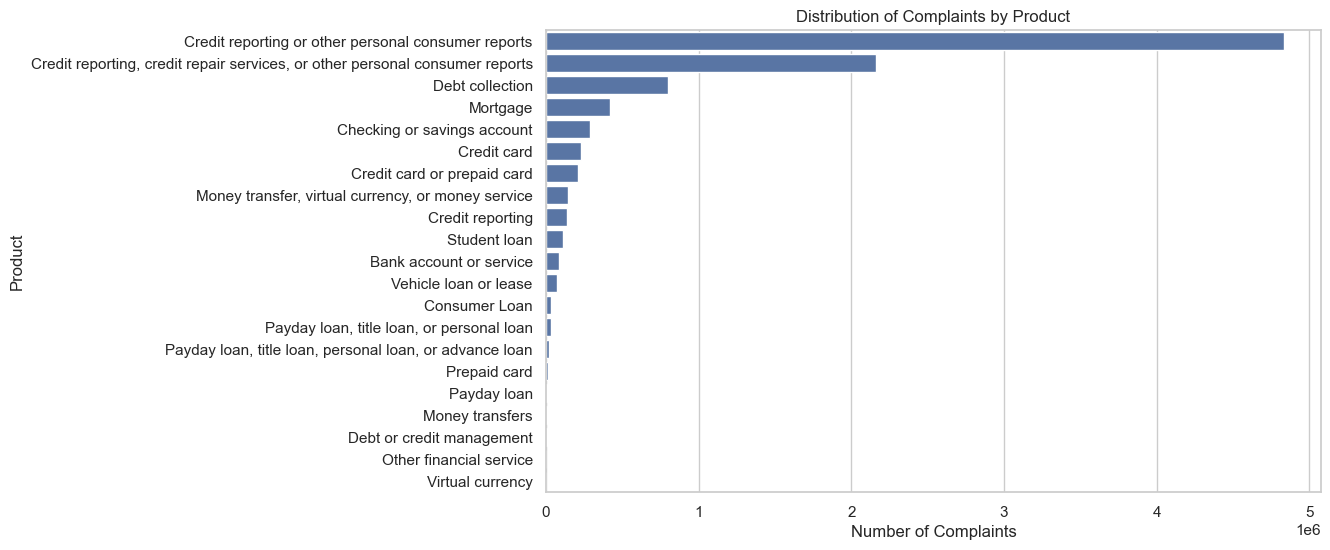

In [5]:
product_counts = df["Product"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=product_counts.values,
    y=product_counts.index
)
plt.title("Distribution of Complaints by Product")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.show()


In [6]:
df["narrative_word_count"] = (
    df["Consumer complaint narrative"]
    .dropna()
    .apply(lambda x: len(str(x).split()))
)

df["narrative_word_count"].describe()


count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_word_count, dtype: float64

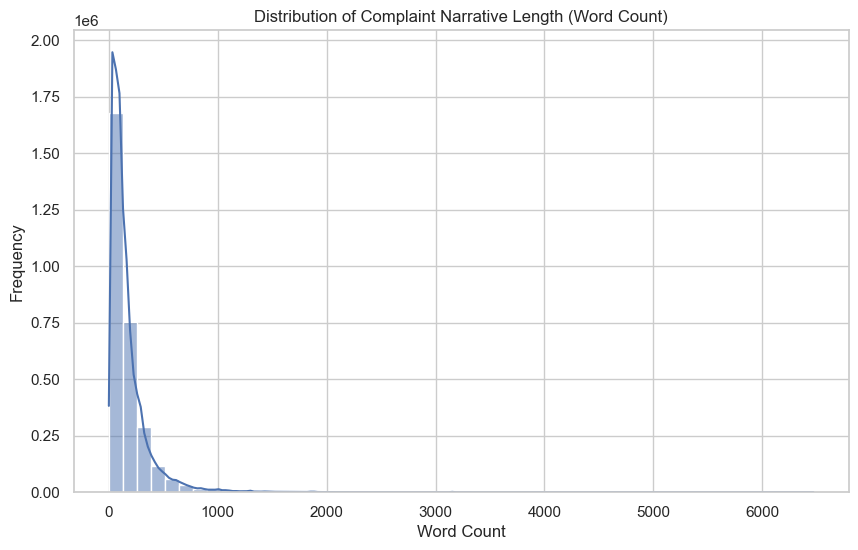

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df["narrative_word_count"], bins=50, kde=True)
plt.title("Distribution of Complaint Narrative Length (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [8]:
with_narrative = df["Consumer complaint narrative"].notna().sum()
without_narrative = df["Consumer complaint narrative"].isna().sum()

print(f"Complaints WITH narrative: {with_narrative}")
print(f"Complaints WITHOUT narrative: {without_narrative}")


Complaints WITH narrative: 2980756
Complaints WITHOUT narrative: 6629041


In [9]:
target_products = [
    "Credit card",
    "Personal loan",
    "Savings account",
    "Money transfer"
]

df_filtered = df[df["Product"].isin(target_products)].copy()

print("After product filtering:", df_filtered.shape)


After product filtering: (226686, 19)


In [10]:
df_filtered = df_filtered[
    df_filtered["Consumer complaint narrative"].notna()
]

print("After removing empty narratives:", df_filtered.shape)


After removing empty narratives: (80667, 19)


In [11]:
def clean_text(text):
    text = text.lower()
    
    # Remove boilerplate phrases
    boilerplate_patterns = [
        r"i am writing to file a complaint",
        r"this complaint is regarding",
        r"please help me with",
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, "", text)
    
    # Remove special characters & extra spaces
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


In [12]:
df_filtered["clean_narrative"] = df_filtered[
    "Consumer complaint narrative"
].apply(clean_text)

df_filtered[["Consumer complaint narrative", "clean_narrative"]].head()


,Consumer complaint narrative,clean_narrative
12237,A XXXX XXXX card was opened under my name by a...,a xxxx xxxx card was opened under my name by a...
13280,"Dear CFPB, I have a secured credit card with c...",dear cfpb i have a secured credit card with ci...
13506,I have a Citi rewards cards. The credit balanc...,i have a citi rewards cards the credit balance...
13955,b'I am writing to dispute the following charge...,b i am writing to dispute the following charge...
14249,"Although the account had been deemed closed, I...",although the account had been deemed closed i ...


In [13]:
OUTPUT_PATH = Path("../data/processed/filtered_complaints.csv")
df_filtered.to_csv(OUTPUT_PATH, index=False)

print(f"Saved cleaned dataset to {OUTPUT_PATH}")


Saved cleaned dataset to ..\data\processed\filtered_complaints.csv
